# Problem 1

Implement the following three methods to generate $100,000$ i.i.d. samples of $X\sim N(0, 1)$.  In each case, plot a histogram of your samples and estimate the average number of uniform random variables required per sample and the average computation time required per sample.

1) Acceptance-rejection with $g(x) = 0.5e^{x}1_{(-\infty, 0]}(x) + 0.5e^{-x}1_{[0, \infty)}(x)$ and $a = \sqrt{2e/\pi}$.

2) The Box-Muller algorithm.  Be sure to use all of the samples you generate.

3) The Marsaglia-Bray algorithm.  Be sure to use all of the samples you generate.

You can time a block of python code with the function `time.perf_counter`.  For example,

## 1 Acceptance-rejection

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(12)

$$
g(x) = 0.5 e^x \mathbf 1_{x < 0} + 0.5 e^{-x} \mathbf 1_{x \geq 0}
$$

Recall the following property of an Exponential r.v. X,
if
$$
\begin{aligned}
X &\sim \text{Exp}(\lambda) \\
\\
f_X(x) &= \begin{cases}
\lambda e^{-\lambda x} \qquad &x \geq 0\\
0 \qquad &o.w.
\end{cases}
\\
\\
X &= -\frac{1}{\lambda}\ln(U) \\
\text{where } U &\sim \text{Unif}(0,1)
\end{aligned}
$$

for a random variable $Y$ with a pdf $f_Y$, if
$$
f_{Y_1}(y_1) = e^{-y_1} \mathbf 1_{x \geq 0} = \begin{cases}
e^{-y_1}  &x \geq 0\\
0  &o.w.
\end{cases}
= e^{-y_1} \mathbf{1}_{y_1 \geq 0} 
 \quad \Rightarrow \quad Y_1 \sim \text{Exp}(-1)
$$

Now consider the following change of variable, $Y_2 = - Y_1$, where the inverse
transform is given by, $y_1 = -y_2$ and the jacobian is $\frac{dy_1}{dy_2} = -1$.

$$
f_{Y_2}(y_2) = f_{Y_1}(-y_2)\cdot|-1| = 
\begin{cases} 
e^{y_2} &y_2 < 0\\
0  &o.w.
\end{cases}
= e^{y_2} \mathbf{1}_{y_2 < 0} 
\quad \Rightarrow \quad -Y_2 \sim \text{Exp}(-1)
$$

$$
\begin{aligned}
g(x) &= 0.5 e^x \mathbf 1_{x < 0} + 0.5 e^{-x} \mathbf 1_{x \geq 0} \\ 
&= \frac{1}{2} \cdot f_{Y_2}(y_2) + \frac{1}{2} \cdot f_{Y_1}(y_1)
\end{aligned}
$$
$$\text{where } Y_2 = -Y_1
\text{ and } Y_1 \sim \text{Exp}(-1) \\
$$

Thus, we use the composition method by generating $Y_1 \sim \text{Exp}(-1)$ and multiply -1 with
0.5 probability.
$Y_1$ can be generated with $Y_1 = \ln(U)$ where $U \sim \text{Unif}(0, 1)$.

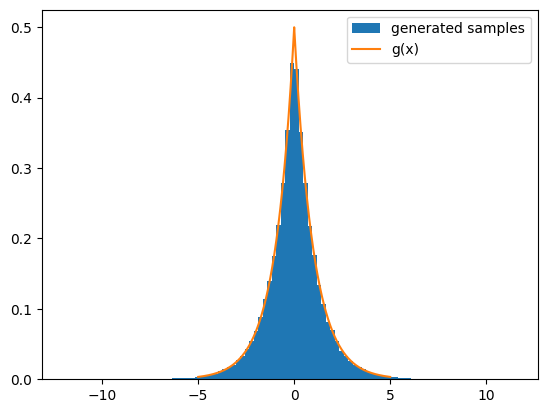

In [2]:
size = int(1e5)

def sample_v(size:int) -> np.array:
    u1, u2 = np.random.random((2, size))
    v = np.log(u1)
    idx = u2 < 0.5
    v[idx] *= -1

    return v

v = sample_v(size)

def g(x):
    return (x <= 0) * 0.5 * np.exp(x) + (x > 0) * 0.5 * np.exp(-x)


x = np.linspace(-5, 5, size)

plt.hist(v, bins=100, density=True, label='generated samples')
plt.plot(x, g(x), label="g(x)")
plt.legend()
plt.show()


In [3]:
a = np.sqrt(2 * np.e / np.pi)
def f(x):
    return np.exp(-(x ** 2) / 2) / np.sqrt(2 * np.pi)


In [4]:
def acc_rej(size):
    out = np.empty(size)
    i = num_unif = 0

    while i < size:
        v = sample_v(1)
        u = np.random.random()
        num_unif += 1

        if a * g(v) * u <= f(v):
            out[i] = v
            i += 1

    return out, num_unif

smpls, num_unif_ar = acc_rej(size)

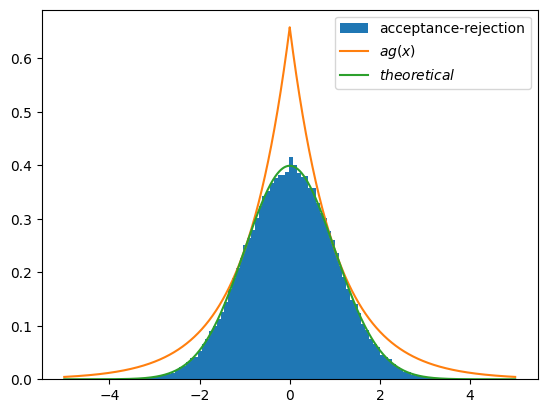

In [5]:
plt.hist(smpls, bins=100, density=True, label='acceptance-rejection')
plt.plot(x, a * g(x), label=r'$ag(x)$')
plt.plot(x, f(x), label=r'$theoretical$')
plt.legend()
plt.show()


## 2 Box-Muller algorithm

In [6]:
def box_muller(n:int = 1000):
    out = np.empty(n)
    
    m = (n + 1) // 2
    size = (2, m)
    lamda = 1 / 2

    u1, u2 = np.random.random(size)
    num_unif = 2 * m

    v = -np.log(u1) / lamda
    w = u2 * 2 * np.pi

    x = np.sqrt(v) * np.cos(w)
    y = np.sqrt(v) * np.sin(w)

    out[:m] = x
    out[-m:] = y

    return out, num_unif

smpls, num_unif_bm = box_muller(size)

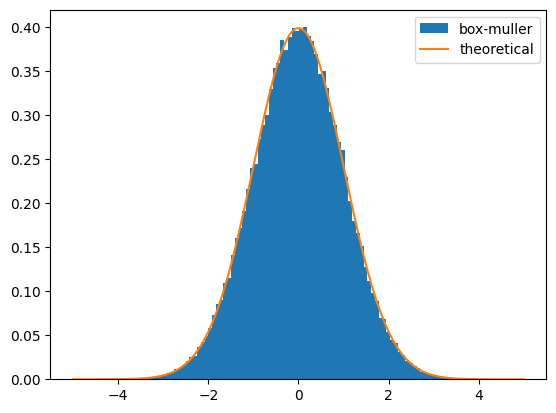

In [7]:
plt.hist(smpls, 100, density=True, label = "box-muller")
plt.plot(x, f(x), label = "theoretical")
plt.legend()
plt.show()

## 3 Marsagilia-Bray

In [8]:
size = int(1e5)
def marsagilia_bray(size: int):
    out = np.empty(size)
    m = (size + 1) // 2

    tmp = np.empty((3, m))
    i = num_unif = 0

    while i < m:
        u1, u2 = np.random.uniform(-1, 1, size=2)
        num_unif += 2

        u = u1 ** 2 + u2 ** 2

        if u <= 1:
            tmp[:, i] = u1, u2, u
            i += 1

    u = tmp[2]
    z1, z2 = tmp[:2] * np.sqrt(-2 * np.log(u) / u)

    out[:m] = z1
    out[-m:] = z2

    return out, num_unif

smpls, num_unif_mb = marsagilia_bray(size)

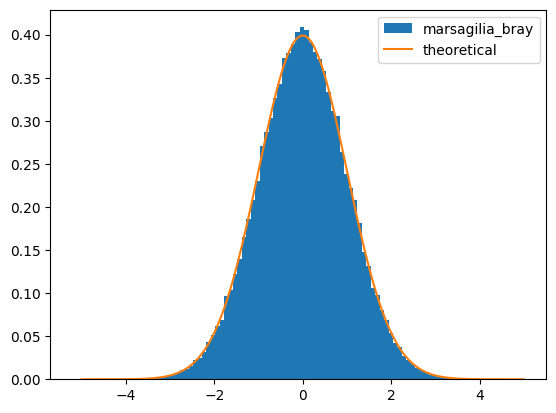

In [9]:
x = np.linspace(-5, 5, size)

plt.hist(smpls, 100, density=True, label='marsagilia_bray')
plt.plot(x, f(x), label="theoretical")
plt.legend()
plt.show()

### Acceptance-Rejection

In [10]:
result = %timeit -o acc_rej(size)

1.48 s ± 6.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
print(f"Avg number of uniform samples required  : {num_unif_ar / size:.4f}")
print(f"Avg number of computation time  required: {result.average / size}")

Avg number of uniform samples required  : 1.3138
Avg number of computation time  required: 1.4756457619999997e-05


### Box-Muller

In [12]:
result = %timeit -o box_muller(size)

2.07 ms ± 13.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
print(f"Avg number of uniform samples required  : {num_unif_bm / size:.4f}")
print(f"Avg number of computation time  required: {result.average / size:}")

Avg number of uniform samples required  : 1.0000
Avg number of computation time  required: 2.0744293428571478e-08


### Marsagilia-Bray

In [14]:
result = %timeit -o marsagilia_bray(size)

118 ms ± 907 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
print(f"Avg number of uniform samples required  : {num_unif_mb / size:.4f}")
print(f"Avg number of computation time  required: {result.average / size}")

Avg number of uniform samples required  : 1.2753
Avg number of computation time  required: 1.1776846845714278e-06


# Problem 2

Consider a three-state, discrete time Markov chain with states $1$, $2$ and $3$ and transition matrix

$$P = \begin{pmatrix} 0.9 & 0.07 & 0.03 \\ 0.12 & 0.8 & 0.08 \\ 0.2 & 0.3 & 0.5 \end{pmatrix}$$

1) Using a uniformly distributed initial condition, generate one trajectory from $t = 0$ to $t = 100,000$ of this Markov chain and plot the first 500 time steps of the trajectory.

2) Use the full trajectory you calculated in part (1) to estimate the expected proportion of time spent in each state.

3) Calculate the dominant eigenvalue of $P$ and its corresponding left eigenvector.  How does this eigenvector relate to the expected times you found in part (2)?

In [16]:
np.random.seed(12)
num_steps = int(1e5)

p_mat = np.array([
    [.9, .07, .03],
    [.12, .8, .08],
    [.2, .3, .5],
])

traj = np.empty(num_steps, int)

unif_cdf = np.array([1/3, 2/3, 1])
u = np.random.random()
traj[0] = int(sum(u > unif_cdf))
x = np.eye(3)[traj[0]]

for i in range(1, num_steps):
    cdf = (x.T @ p_mat).cumsum()
    u = np.random.random()
    traj[i] = int(sum(u > cdf))
    x = np.eye(3)[traj[i]]
    

## 1

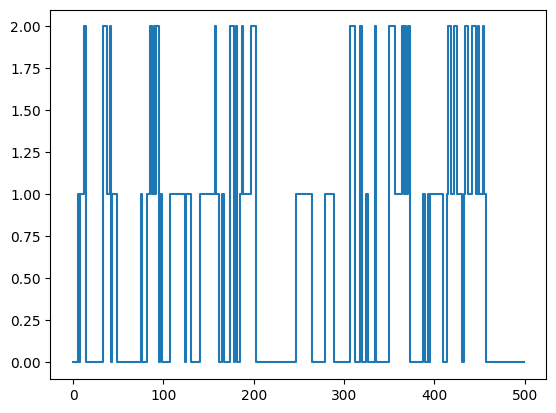

In [17]:
plt.step(np.arange(500), traj[:500], where='post')
plt.show()

## 2

In [18]:
_, cnt = np.unique(traj, return_counts=True)
freq = cnt / num_steps
freq.round(4)

array([0.5805, 0.3318, 0.0877])

## 3

In [19]:
eig_val, eig_vec = np.linalg.eig(p_mat.T)
stationary_dist = eig_vec[:, 0] / sum(eig_vec[:, 0])
print(f"Principal eigen value     : {eig_val[0]:.4f}")
print(f"corresponding eigen vector: {eig_vec[:, 0].round(4)}")
print(f"scaled eigen vector       : {stationary_dist.round(4)}")


Principal eigen value     : 1.0000
corresponding eigen vector: [0.858  0.4967 0.131 ]
scaled eigen vector       : [0.5775 0.3343 0.0881]


If we scale the principal eigenvector so that it sum up to 1, the scaled
eigenvector is the stationary distribution of the markov chain. The long-term
visiting
frequency of each state or equivalently, the expected proportion of time spent in each state should converge to the stationary distribution as $t \rightarrow \infty$.

By definition of eigenvalue and eigenvector, we have
$$
\begin{aligned}
\mathbf{v}^TP = \lambda \mathbf{v}^T
\end{aligned}
$$
where $\mathbf{v}$ is the eigenvector with the corresponding eigenvalue of $\lambda=1$

We can devide the BHS by the sum of all elements in a vector $a:=\mathbf{1}^T\mathbf{v}
= \sum v_i$. That is,
$$
\begin{aligned}
\mathbf{v}^TP &= \mathbf{v}^T \\
\frac{1}{a} \mathbf{v}^TP &=
\frac{1}{a} \mathbf{v}^T \\
\pi^TP &= \pi^T \quad \text{where }\pi:= \frac{1}{a} \mathbf{v}
\end{aligned}
$$

Since $\pi^TP = \pi^TP^n = \pi^T$, for $\forall n \in
\{1, 2, \cdots\}$, $\pi$ is the stationary distribution of the Markov chain.

# Problem 3

Suppose that an insurance company pays out $N\sim \textrm{Poisson}(10)$ claims per week and the payout for each claim is $X_i \sim \textrm{Exp}(0.1)$.  (All of the random variables $N$ and $X_i$ are mutually independent.)  The total amount that the insurance company needs to pay out each week is given by

$$X = \sum_{i = 1}^{N}X_i$$

Use the composition method to generate at least $100,000$ i.i.d. samples of $X$.  Plot a histogram of your samples and report the sample mean and variance.

In [20]:
from collections import defaultdict

def poisson(lamda:int , size: int) -> np.array:
    out = np.empty(size, int)
    cdf = defaultdict(float) # hashmap for a poisson cdf
    cdf[0] = np.exp(-lamda)

    for i in range(size):
        n = 0
        p = cdf[0]

        u = np.random.random()

        while u > cdf[n]:
            p = lamda * p / (n + 1)
            if cdf[n+1] == 0:
                cdf[n+1] += cdf[n] + p
            n += 1

        out[i] = n
    
    return out

size = int(1e6)
n = poisson(10, size)


In [21]:
def exponential(lamda, size):
    u = np.random.random(size)
    return -np.log(u)/lamda


x = np.empty(size)
for i in range(size):
    x[i] = exponential(0.1, n[i]).sum()


Mean: 99.9678 	 Var: 1999.9063


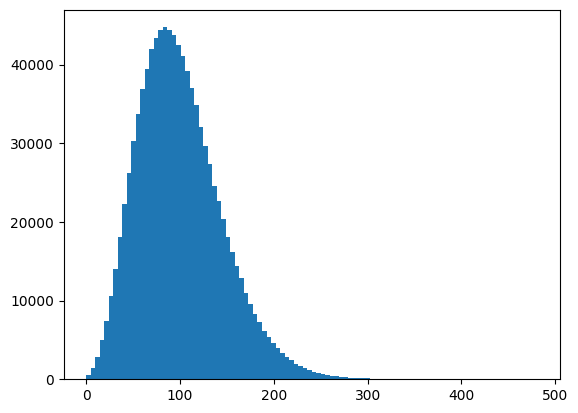

In [22]:
print(f"Mean: {x.mean():.4f} \t Var: {x.var():.4f}")
plt.hist(x, 100)
plt.show()

# Problem 4

Consider the multivariate normal random variable $X\sim N(\mathbf{0}, \Sigma)$, where

$$\Sigma = \begin{pmatrix} 1 & -1 \\ -1 & 1 \end{pmatrix}$$

1) What is the Cholesky decomposition of $\Sigma$?  Explain why it might be problematic to generate samples of $X$ using this decomposition.

2) What is the pdf of $X$?

2) Generate $1,000$ samples of $X$ and make a scatter plot of the points.  How does this plot relate to your answer from parts (1) and (2)?

## 1
The characteristic polynomial of $\Sigma$ is given by,
$$
\begin{aligned}
|\Sigma - \lambda I| &= \left|\begin{matrix} 1-\lambda & -1 \\ -1 & 1-\lambda
\end{matrix}\right| \\
&= \det\left(\begin{matrix} 1-\lambda & -1 \\ -1 & 1-\lambda
\end{matrix}\right) \\ 
&= (1-\lambda)^2 -1
\end{aligned}
$$

The eigenvalue of $\Sigma$ is the solutions of the characteristic equation

$$
(1-\lambda)^2 - 1 = 0
$$

$$
\lambda_1 = 2, \lambda_2 = 0
$$

Since $\lambda_2$ is 0, $\Sigma$ is not positive definete, but only positive
semidefinite.

Thus, we can get the following $LDL^T$ decomposition.


$$
\begin{aligned}
\Sigma &= LDL^T \\
&= \begin{pmatrix} 1 & 0 \\ L_{21} & 1 \end{pmatrix}
\begin{pmatrix} D_1 & 0 \\ 0 & D_2 \end{pmatrix}
\begin{pmatrix} 1 & L_{12} \\ 0 & 1 \end{pmatrix} \\ 
&= \begin{pmatrix} D_1 & D_1L_{12} \\ L_{21}D_1 & L_{21}D_1L_{12} + D_2 \end{pmatrix}
\end{aligned}
$$

$$
\begin{pmatrix} D_1 & D_1L_{12} \\ L_{21}D_1 & L_{21}D_1L_{12} + D_2
\end{pmatrix} = \begin{pmatrix} 1 & -1 \\ -1 & 1 \end{pmatrix}
$$

$$
D_1 = 1 \\ D_2 = 0\\
L_{12} = L_{21} = -1 \\
$$

That is,
$$
\begin{aligned}
\Sigma &= \begin{pmatrix} 1 & 0 \\ -1 & 1 \end{pmatrix}
\begin{pmatrix} 1 & 0 \\ 0 & 0 \end{pmatrix}
\begin{pmatrix} 1 & -1 \\ 0 & 1 \end{pmatrix} \\ 
&= \begin{pmatrix} 1 & 0 \\ -1 & 1 \end{pmatrix}
\begin{pmatrix} 1 & 0 \\ 0 & 0 \end{pmatrix}
\begin{pmatrix} 1 & 0 \\ 0 & 0 \end{pmatrix}
\begin{pmatrix} 1 & -1 \\ 0 & 1 \end{pmatrix} \\ 
&= \begin{pmatrix} 1 & 0 \\ -1 & 0 \end{pmatrix}
\begin{pmatrix} 1 & -1 \\ 0 & 0 \end{pmatrix} \\ 
&= AA^T
\end{aligned}
$$

If we sample $X$ from this decomposition $A$,
That is, 
$X = \mu + A  Z$ where $Z = (Z_1, Z_2)^T \sim N(0, I)$
$$
X = 
\begin{pmatrix}
0 \\
0
\end{pmatrix}
+
\begin{pmatrix}
1 & 0 \\
-1 & 0
\end{pmatrix}
\begin{pmatrix}
Z_1 \\
Z_2
\end{pmatrix}
= \begin{pmatrix}
Z_1 \\
-Z_1
 \end{pmatrix}
$$

Thus, this method discards all the generated $z_2$ and this will cause a significant
computational inefficiency. Because this method is generating the twice of
the number of samples that is acutally needed.

## 2
$X$ does not have a two dimensional density, but only has a one dimensional
normal density as follows.

$$
f_X(\mathbf{x}) = \begin{cases}
\frac{1}{\sqrt{2\pi}}\exp\left(-\frac{x_1^2}{2}\right) &
\text{if }x_2 = -x_1 \\
0 &o.w
\end{cases}
$$

## 3

In [23]:
a_mat = np.array([[1, 0], [-1, 0]])

x = np.empty((size, 2))

for i in range(size):
    z, _ = box_muller(2)
    x[i] = a_mat @ z.T


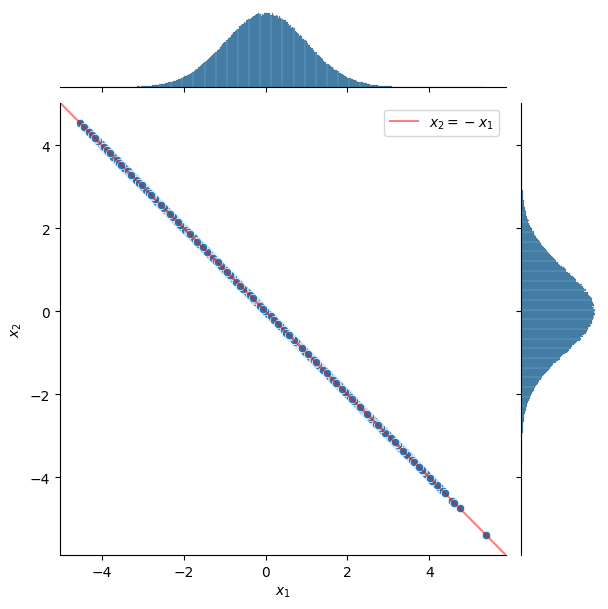

In [24]:
import seaborn as sns

sns.jointplot(x=x[:, 0], y=x[:, 1])
plt.axline([0,0], [1, -1], color="red", alpha=.5, label=r"$x_2 = -x_1$")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.legend()
plt.show()

The generated samples lie on the negative identity line, indicating that the
support of the joint distribution of $X$ is a line of $X_2 = -X_1$. That is,
random vector $X$ has a one dimensional standard normal density, which is
consistent with the result of the part 1 and 2.

# Problem 5

Suppose $S\sim GBM(0.1, 0.09)$.  In this problem, you will simulate $S_{t_k}$ at the times $t_k = 0.01k$ for $0 \leq k \leq 1000$.  Use the initial condition $S_0 = 1$.

1) Simulate $S$ once and plot the trajectory.

2) Simulate $S$ at least $10,000$ times and plot the mean trajectory.

3) Estimate the probability that the maximum of $S_{t_k}$ is no greater than 6.

4) Estimate the probability that $S_{t_k}$ ever leaves the interval $[0.25, 10]$.

In [25]:
np.random.seed(12)

mu = 0.1
sigma = 0.09

dt = 0.01
T = 1000
t = np.arange(T+1) * dt
S_0 = 1

size = 10000

s = np.ones((size, len(t)))
s[:, 0] = S_0
s_T = np.empty(size)

mean = (mu - sigma ** 2 / 2) * dt
sd = sigma * np.sqrt(dt)

for k in range(size):
    z, _ = box_muller(1000)
    log_diff = mean + sd * z
    s[k, 1:] = s[k, 0] * np.exp(log_diff).cumprod()
    s_T[k] = s[k, -1]


## 1

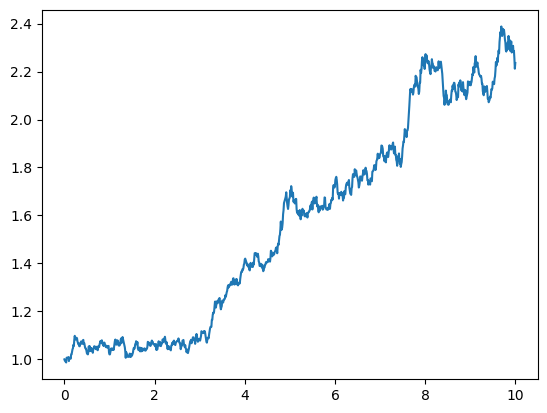

In [26]:
plt.plot(t, s[0])
plt.show()

## 2

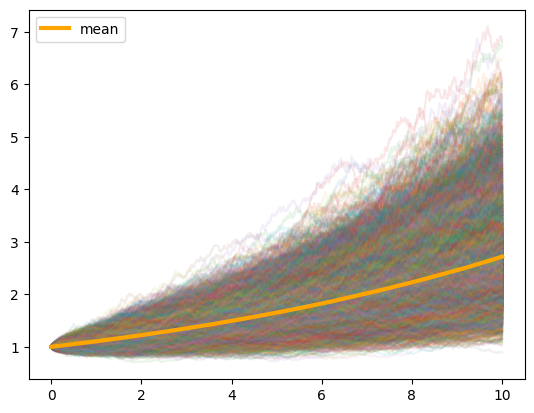

In [27]:
for i in range(size):
    plt.plot(t, s[i], alpha=0.1)
plt.plot(t, s.mean(0), color='orange', lw=3, label='mean')
plt.legend()
plt.show()

## 3

$$
P[\max{(S_{t_k})} \leq 6] =
$$

In [28]:
np.mean(s.max(1) <= 6)

0.9984

## 4

$$
P[\min{(S_{t_k})} < 0.25 \text{ or }\max{(S_{t_k})} > 10] = 1 -
P[\min{(S_{t_k})} \geq 0.25 \text{ and }\max{(S_{t_k})} \leq 10] =
$$

In [30]:
1 - np.mean((s.min(1) >= 0.25) * (s.max(1) <= 10))


0.0